# Materials introduction

Materials can be defined as pure elements

In [1]:
from spectrocrunch.materials import element

element1 = element.Element("Ca")
print(element1)

Ca


as compounds

In [2]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromname
from spectrocrunch.materials import compoundfromlist
from spectrocrunch.materials import types

compound1 = compoundfromformula.CompoundFromFormula("PbSO4",density=6.29)
compound2 = compoundfromformula.CompoundFromFormula("CaSO4",density=2.32)
compound3 = compoundfromname.compoundfromname("linseed oil")
compound4 = compoundfromlist.CompoundFromList(["Ca","C","O"],[1,1,3],\
                                             types.fraction.mole,2.71,name="calcite")
print(compound1,compound2,compound3,compound4)

(PbSO4, CaSO4, linseed oil, calcite)


and as mixtures of compounds

In [3]:
from spectrocrunch.materials import mixture

mixture1 = mixture.Mixture([compound1,compound2],[0.5,0.5],\
                           types.fraction.mass,name="My mixture")
print(mixture1)

50.00 wt% PbSO4 + 50.00 wt% CaSO4


These materials can be used in a particular geometry (currently only flat multi-layered samples)

In [4]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",detectorposition=-15.,detector=detector,source=source)

sample = multilayer.Multilayer(material=[element1,compound1,mixture1],\
                               thickness=[1e-4,1e-4,1e-4],geometry = geometry)
print(sample)
print("")
print(geometry)

Multilayer (ordered top-bottom):
 Layer 0. 1.0 um (Ca)
 Layer 1. 1.0 um (PbSO4)
 Layer 2. 1.0 um (50.00 wt% PbSO4 + 50.00 wt% CaSO4)

Source:
 intensity = 1.0 (W/m^2)
 dop = 0.7
 dolp = 0.665
 polangle = 0.0 (deg)
 handedness = left
XRF detector:
 Active area = 80.0 mm ** 2
 Ionization energy = 3.66856052632 eV
 Material = Si (0.045 cm)
Beam filters: None
Attenuators:
 ultralene = 0.0004 cm
 Be = 0.0025 cm
MCA:
 zero = 0.0 eV
 gain = 5.0 eV
 noise = 50.0 eV (FWHM)
 fano = 0.19
Geometry:
 In = 62 deg
 Out = 49 deg (reflection)
 Azimuth = 0.0 deg
 Distance = 41.5 mm
 Solid angle = 4*pi*0.00365594984903 srad
 Detector position = -15.0 mm


## Cross sections

The main usage of the material classes is to calculate cross sections. Current back-ends are [xraylib](https://github.com/tschoonj/xraylib) (elemental database, neglecting environment) and [FDMNES](http://neel.cnrs.fr/spip.php?rubrique1007&lang=en) (calculation with environment).

- Mass attenuation coefficient (absorption + scattering)
- Total scattering cross section
- Rayleigh cross section
- Compton cross section
- Mass absorption coefficient (total photoionization cross-section) 

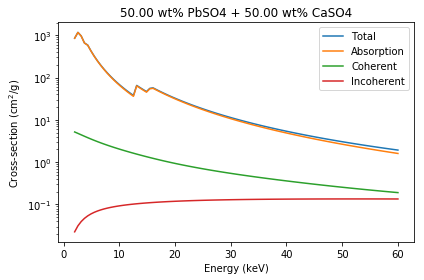

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

energy = np.linspace(2,60,100)
material = mixture1

mu = material.mass_att_coeff(energy)
plt.plot(energy,mu,label='Total')
mu = material.mass_abs_coeff(energy)
plt.plot(energy,mu,label='Absorption')
mu = material.rayleigh_cross_section(energy)
plt.plot(energy,mu,label='Coherent')
mu = material.compton_cross_section(energy)
plt.plot(energy,mu,label='Incoherent')

plt.title(str(material))
plt.xlabel('Energy (keV)')
plt.ylabel('Cross-section (cm$^2$/g)')
plt.legend(loc='best')
plt.gca().set_yscale('log', basey=10)

plt.tight_layout()
plt.show()

## Partial cross sections
- Partial photoionization cross section of a shell (fraction of absorption cross section)
- Fluorescence cross section of an emission line: product of
 - the partial photoionization cross section of the excited shell
 - the fluorescence yield of the excited shell (fraction of shell cross section)
 - the radiative rate of the emission line (fraction of fluorescence yield)

Partial cross-section: no selection
My mixture
 PbSO4
  Scatterer: yes
  Pb (no ionized shells)
  S (no ionized shells)
  O (no ionized shells)
 CaSO4
  Scatterer: yes
  Ca (no ionized shells)
  S (no ionized shells)
  O (no ionized shells)

Partial cross-section: selected Ca-K
My mixture
 PbSO4
  Scatterer: yes
  Pb (no ionized shells)
  S (no ionized shells)
  O (no ionized shells)
 CaSO4
  Scatterer: yes
  Ca ionized shells:
   K fluorescence lines: all
  S (no ionized shells)
  O (no ionized shells)

Partial cross-section: selected Ca-Ka
My mixture
 PbSO4
  Scatterer: yes
  Pb (no ionized shells)
  S (no ionized shells)
  O (no ionized shells)
 CaSO4
  Scatterer: yes
  Ca ionized shells:
   K fluorescence lines: KA
  S (no ionized shells)
  O (no ionized shells)


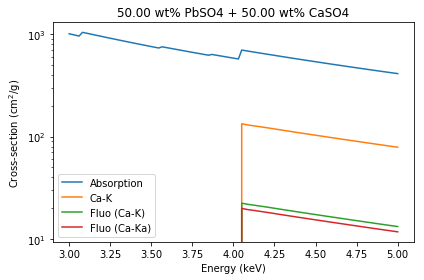

In [6]:
material = mixture1
material.unmarkabsorber()
print("Partial cross-section: no selection")
print('\n'.join(list(material.markinfo())))

energy = np.linspace(3,5,100)
mu = material.mass_abs_coeff(energy)
plt.plot(energy,mu,label='Absorption')

material.unmarkabsorber()
material.markabsorber("Ca",shells=['K'])
print("\nPartial cross-section: selected Ca-K")
print('\n'.join(list(material.markinfo())))

mu = material.partial_mass_abs_coeff(energy)
plt.plot(energy,mu,label='Ca-K')

mu = material.fluorescence_cross_section(energy)
plt.plot(energy,mu,label='Fluo (Ca-K)')

material.unmarkabsorber()
material.markabsorber("Ca",shells=['K'],fluolines=['KA'])
print("\nPartial cross-section: selected Ca-Ka")
print('\n'.join(list(material.markinfo())))

mu = material.fluorescence_cross_section(energy)
plt.plot(energy,mu,label='Fluo (Ca-Ka)')

plt.title(str(material))
plt.xlabel('Energy (keV)')
plt.ylabel('Cross-section (cm$^2$/g)')
plt.legend(loc='best')
plt.gca().set_yscale('log', basey=10)

plt.tight_layout()
plt.show()

material.unmarkabsorber()

## Differential cross sections

The following differential cross sections with respect to the solid angle are available:

- Rayleigh scattering (anisotropic)
- Compton scattering (anisotropic)
- Fluorescence (isotropic)

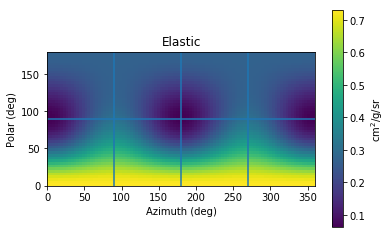

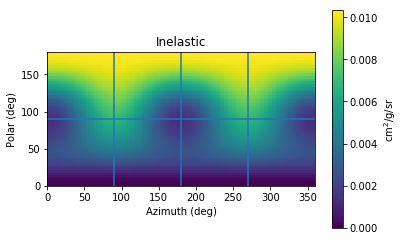

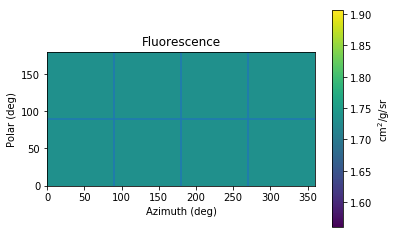

In [11]:
azimuth = np.linspace(0,360,100)
polar = np.linspace(0,180,50)
extent = [azimuth[0],azimuth[-1],polar[0],polar[-1]]
azimuth,polar = np.meshgrid(np.radians(azimuth),np.radians(polar))

energy = 5
material = mixture1

def plotcs(cs):
    plt.imshow(cs,origin="lower",extent=extent)
    plt.axhline(y=90)
    for x in [90,180,270]:
        plt.axvline(x=x)
    plt.xlabel("Azimuth (deg)")
    plt.ylabel("Polar (deg)")
    plt.colorbar(label="cm$^2$/g/sr")
    
cs = material.diff_rayleigh_cross_section(energy,source=source)
plotcs(cs(azimuth,polar))
plt.title("Elastic")
plt.show()

cs = material.diff_compton_cross_section(energy,source=source)
plotcs(cs(azimuth,polar))
plt.title("Inelastic")
plt.show()

material.markabsorber(energybounds=[1,energy])
cs = material.diff_fluorescence_cross_section(energy,source=source)
cs = np.full_like(azimuth,sum(cs.values()))
plotcs(np.full_like(azimuth,cs))
plt.title("Fluorescence")
plt.show()

X-ray spectra
------------

X-ray spectra are calculated from the cross-sections (including self-absorption). Alternatively the [fisx](https://github.com/vasole/fisx) library can be used as a back-end (no scattering; including self-absorption and secondary fluorescence).

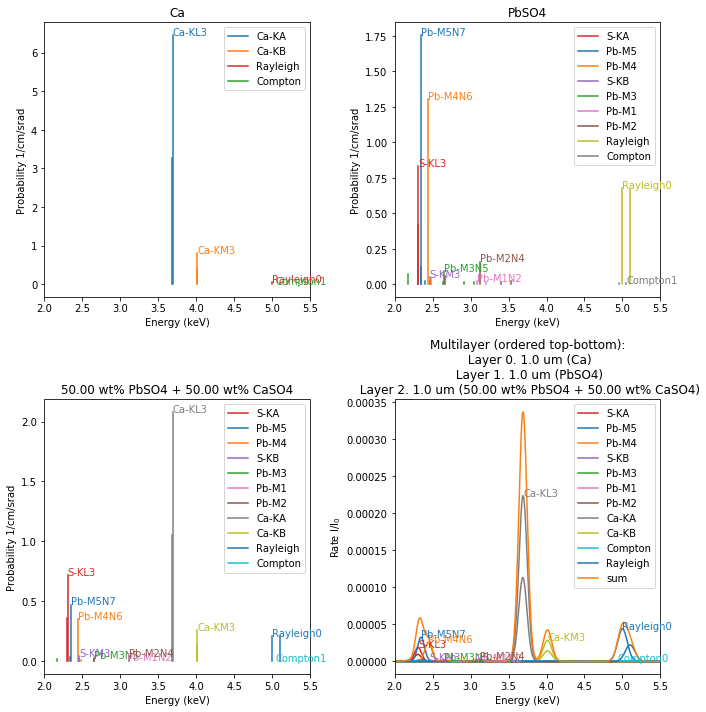

In [17]:
fig,axs = plt.subplots(2,2,figsize=(10,10))

energy = [5,5.1]
weights = [2,1]

emin = 2
emax = 5.5

plt.sca(axs[0][0])
spectrum = element1.xrayspectrum(energy,weights=weights,\
                                 emax=emax,emin=emin,source=source)
spectrum.plot()

plt.sca(axs[0][1])
spectrum = compound1.xrayspectrum(energy,weights=weights,\
                                 emax=emax,emin=emin,source=source)
spectrum.plot()

plt.sca(axs[1][0])
spectrum = mixture1.xrayspectrum(energy,weights=weights,\
                                 emax=emax,emin=emin,source=source)
spectrum.plot()

plt.sca(axs[1][1])
spectrum = sample.xrayspectrum(energy,weights=weights,\
                                 emax=emax,emin=emin)
spectrum.plot()

plt.tight_layout()
plt.show()

Other physical properties
------------------------
 - Atomic form factor
 - Complex refractive index